In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

import numpy as np
from itertools import zip_longest
import itertools as itertools

In [2]:
def prepareCsvForPkgId(input_file, returnjustfile = False):
    """
    Input:
        file (string): Is a csv produced by the app after 11.09.2020 containing info on the package ID. 
        returnjustfile (boolean = False): If true, only the file and not the list with Marc's ids, the filename and  the evenly index as list is returned
    Returns:
        file (dataframe): A kind of cleaned dataframe with an evenly space timestamp as index 
        ids (list): A list with the package ids as ints
        filename (string): The name of the experiment (if the name given from the app, including the timestamp) was used)
        index_evenly (array): The evenly spaced index as a list
    """
    file = pd.read_csv(input_file)
    file = file.iloc[1:]
    file.columns = file.iloc[0]

    file = file[1:].apply(pd.to_numeric, errors='ignore')

    # to evenly set the timestamps 
    length = len(file.index) # length of dataframe
    stop = length*4 # stop point 
    index_evenly = np.linspace(0, stop, num = length, endpoint = False) # to adapt timestamp  
    file.loc[:,"Time"] = index_evenly #set the time as index, relevant for later plotting

    ids= file.index.tolist() # these are all the package ids (as strings because, yes pandas of course we want that as strings, strings are soooo useful..Not)
    ids = [int(one_id) for one_id in ids] # now they are ints
    #print(ids)

    file.set_index('Time', inplace=True)
    # 
    filename = input_file[0:6]+input_file[20:-4]
    if returnjustfile:
        return file
    else:
        return file, ids, filename, index_evenly # no idea why, but the name of the index still includes "Pkg ID", the id not actually the index. Time is .. 
    

def PlotJumpsBoth(justTheFileName,  which ="both", save = False):
    """
    Plots the parts of the Signal where the difference to the next measurement is larger than 3.7, indicating an abnormalty
    Input:
        justTheFileName (string): The name of the csv to be processed. has to be in same folder. 
    """
    name = justTheFileName[0:6]+justTheFileName[20:-4]
    
    withLoss = prepareCsvForPkgId(justTheFileName, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1) 
    
    withLoss = withLoss.dropna(axis = 1, how="all")#, how = 'all')
    dif_plot = withLoss.drop(["Pkg Loss"], axis=1) 

#the df with the difference to the next measurement and Channel 1 info
    dif_plot["Difference"] =dif_plot.diff(axis=0).abs()

    # now really only the difference
    dif_df = dif_plot.drop(["Ch-1"], axis =1)

    # reduce to the ones larger than threshold
    bigger = dif_df[(dif_df >3.7).any(1)]

    # only look at 100 largest difference 
    biggest_differences_df = bigger["Difference"].nlargest(n=100)
    #get the timestamp of the biggest difference
    bd_list = biggest_differences_df.index.tolist() #list of the timestamp when the biggest difference occur
    #sort the list of timestamps to group them (so that they can be plotted more efficiently )
    sortedList = sorted(bd_list)

    # create dictionary of groups of big differences 
    DictOfJumps = dict(enumerate(grouper2(sortedList, closeMeansWithin=100), 1))
    ratio = round( len(bigger.index)/len(dif_plot.index),5)
    print("For ~{}~ and its {} measured data points, {} have an bigger than threshold difference. The ratio is {}. The jumps occur in {} parts of the signal".format(name,len(dif_plot.index),len(bigger.index),ratio,len(DictOfJumps)))

    # combine the "lost package" info with the  difference info for convenient plotting 
    combined = pd.concat([withLoss, dif_df], axis=1)
    if which == "both" or "difference": 
        for key, value in DictOfJumps.items():
            first_jump = value[0]
            first_jump_pos = int(first_jump/4)
            last_jump = value[-1]
            last_jump_pos = int(last_jump/4)
            plot_from = first_jump_pos -45
            if plot_from < 0:
                plot_from = 0
            plot_to = last_jump_pos +45
            if plot_to > len(dif_plot.index):
                plot_to = len(dif_plot.index)
            rangePlot = plot_to - plot_from
            adaptsize = int(rangePlot/10)
            combined.iloc[plot_from:plot_to].plot(marker ='o', title = "{}:There are {} large differences between {} and {} msec".format(name,len(value),first_jump, last_jump),figsize = (adaptsize,5), grid=True)
            if save:
                plt.savefig(name+"_"+str(first_jump)+"_to_"+str(last_jump)+'_msec.png')

        #dif_df.plot(title = "Is there a pattern to where the signal jumps?", figsize = (15,5))
    
    if which == "both" or "lost":
        
        #dif_plot = prepareCsvForPkgId(justTheFile, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1) 

        #dif_plot["Difference"] =dif_plot.diff(axis=0).abs()
        dif_df = withLoss.drop(["Ch-1"], axis =1)
        # find place where the package loss is bigger than 0 
        bigger = dif_df[(dif_df >0).any(1)]

        bd_list = bigger.index.tolist()
        sortedList = sorted(bd_list) # list of the indexed with jumps

        DictOfLosses = dict(enumerate(grouper2(sortedList, closeMeansWithin=100), 1))
        ratio = round( len(bigger.index)/len(dif_plot.index),5)
        total = sum(dif_df["Pkg Loss"])
        print("For ~{}~ and its {} measured data points, {} are lost in transmission. The ratio is {}. \n The losses occur in {} parts of the signal. ".format(name,len(dif_plot.index), total, ratio, len(DictOfJumps)))

        for key, value in DictOfLosses.items():

            first_jump = value[0]
            first_jump_pos = int(first_jump/4)
            last_jump = value[-1]
            last_jump_pos = int(last_jump/4)
            plot_from = first_jump_pos -20
            if plot_from < 0:
                plot_from = 0
            plot_to = last_jump_pos +20
            if plot_to > len(dif_plot.index):
                plot_to = len(dif_plot.index)
            rangePlot = plot_to - plot_from
            adaptsize = int(rangePlot/10)
            combined.iloc[plot_from:plot_to].plot(marker ='o', title = "{}:There are {} packages lost in transmission between {} and {} msec".format(name,len(value),first_jump, last_jump), grid=True , figsize = (adaptsize,5))
            if save:
                plt.savefig(name+"_Packageloss_"+str(first_jump)+"_to_"+str(last_jump)+'_msec.png')     
        #dif_df.plot(title = "Is there a pattern in the timing of lost packages?",figsize = (15,5))
def grouper2(iterable, closeMeansWithin = 50): # from stackoverflow
    """
    Helper function to evaluate if drops and jumps are in the same area
    """
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= closeMeansWithin: # if the values are in a range of 50, they are in the same cycle (approximately)
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

result_dict = {"Name": [], "Total": [], "Complete": [], "Ratio":[]} # to later save the results
result_df = pd.DataFrame(data=result_dict)

def evalCompleteness(IdChunkList, filename, perfectSet =  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}):
    '''
    Checks whether the individual chunks contain all package ids and are hence a complete set where nothing was dropped.
    Prints out a summary and saves the results in a dataframe (result_df)
    Input:
        chunklist(list of list): The list created by grouper
        filename (string): The name of the experiment, as produced by prepareCsvForPkgId() 
        perfectSet (set): The set of values that comprise all possible package ids, given by the app. 
                        Older Csv files contain the old naming ({1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}),
                        Newer ones, the default one ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15})
    '''
    ratio = []
    for chunk in IdChunkList:
        isSet = perfectSet.issubset(set(chunk))
        ratio.append(isSet)
    total = len(ratio)-1 # -1 because the last one usually is never complete
    complete = sum(ratio)
    ratio_abs = complete/total
    
    if ratio_abs < 0.1: 
        ratio = []
        print("Low results of ~{}~ indicate the old encoding scheme:".format(filename))
        perfectSet = {1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}
        for chunk in IdChunkList:
            isSet = perfectSet.issubset(set(chunk))
            ratio.append(isSet)
        total = len(ratio)-1 # -1 because the last one usually is never complete
        complete = sum(ratio)
        ratio_abs = complete/total
    print("Of {} chunks, {} contain all package Ids. The complete to incomplete ratio of the experiment ~{}~ is: {}.".format(total, complete, filename, ratio_abs))
    global result_df
    result_df = result_df.append({"Name": filename, "Total": total, "Complete": complete, "Ratio": ratio_abs}, ignore_index= True, verify_integrity=True)
    result_df.drop_duplicates(inplace=True) # clean that df
    
def analyseMissingAppPackages(filestring, perfectSet = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}):
    '''
    Function combines all steps of analysing missing packages that are dropped by the app  
    Input:
        filestring (string): The name of the file to be analysed, has to be in same directory
        perfectSet (set): The set of values that comprise all possible package ids, given by the app. 
                        Older Csv files contain the old naming ({1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}),
                        Newer ones, the default one ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15})
    '''
    
    file_df, ids_list, filename_string, index = prepareCsvForPkgId(filestring)
    try:
        print("\n Package Loss For", filename_string, "~ ",sum(file_df["Pkg Loss"].tolist()), " ~", "Total Amount of datapoints: ", len(file_df.index))
        print("Adapted (/3 due to BL characteristics) Percentage = ", ((sum(file_df["Pkg Loss"].tolist())/len(file_df.index))*100)/3)
    except KeyError:
        print(" ")
        #print("\n no Pkg Loss available for ", filename_string)
    IdChunkList = grouper(ids_list, 16, 20) # 20 is just a random number bigger than the largest value in set (to fill the last set )
    evalCompleteness(IdChunkList, filename_string, perfectSet)

def grouper(iterable, n, fillvalue=None): # copied from StackOverflow
    '''
    Mostly Copied from StackOverflow. Takes a list and devided it into chunks of length n.
    Returns:
        toReturn: A list containing lists of length n
    '''
    args = [iter(iterable)] * n
    toReturn = list(zip_longest(*args, fillvalue=fillvalue)) # includes now the data types I want to work with (namely list of lists)
    toReturn = [list(oneChunk) for oneChunk in toReturn] # because one cannot turn tuples into sets. 
    return toReturn

14-10-2020_11-54-24_chan1.csv
14-10-2020_11-55-02_chan2.csv
14-10-2020_11-56-15_chan3.csv
14-10-2020_11-57-47_chan4.csv
14-10-2020_11-58-14_chan5.csv
14-10-2020_11-59-25_chan7.csv
14-10-2020_11-59-49_chan8.csv
14-10-2020_12-00-36_chan9.csv
14-10-2020_12-01-20_chan10.csv
14-10-2020_12-01-55_chan11.csv
14-10-2020_12-02-20_chan12.csv
14-10-2020_12-02-51_chan13.csv
14-10-2020_12-03-33_chan14.csv
14-10-2020_12-04-07_chan15.csv
14-10-2020_12-04-46_chan16.csv
14-10-2020_12-05-21_chan17.csv
14-10-2020_12-05-59_chan18.csv
14-10-2020_12-06-33_chan19.csv
14-10-2020_12-06-58_chan20.csv
14-10-2020_12-07-26_chan21.csv
14-10-2020_12-07-54_chan22.csv
14-10-2020_12-08-25_chan23.csv
14-10-2020_14-24-41_ch1_.csv
14-10-2020_14-26-09_ch2_.csv


In [19]:
def plotting_24(filename, save = False):    
    SAMPLINGRATE = 1/167
    test = pd.read_csv(filename, nrows = 1 )
    #print(test)

    df = pd.read_csv(filename,  sep = ",", header = 2, index_col=False) # read csv file
    # calculate step size in accordance to samplingrate (hardcoded) 
    length = len(df.index)
    time = np.arange(0,length*SAMPLINGRATE, step = SAMPLINGRATE)
    if len(time)!= length: # in case the time and the actual recorded datapoints are not of same length
        time=time[:-1]

    df["Time"] = time # include time in df
    #print(df.head())
    # #print(twent)
    df.set_index('Time', inplace = True) # set time as index
    #print(df.head())
    df["Ch-1"].iloc[1000:1400].plot(subplots = True, marker ='o', grid=True  , figsize= (15,15), title = filename)
    if save:
        plt.savefig(filename[:-4]+".png")

['03-11-2020_11-46-53_scale_test.csv', '16-10-2020_14-28-10_50mV5HzCh19.csv', '16-10-2020_14-30-36_50mV5HzCh16.csv']


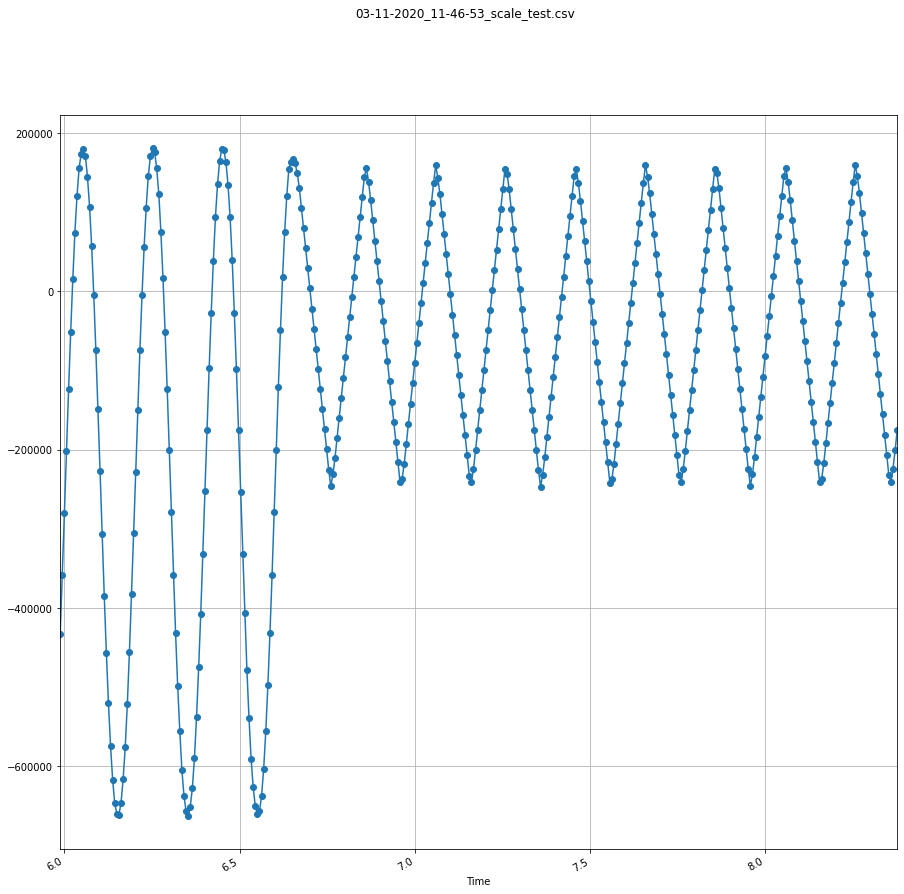

In [21]:
extension = 'csv'
all_csv = glob.glob('*.{}'.format(extension))
print(all_csv)
plotting_24("03-11-2020_11-46-53_scale_test.csv", save=True)
#for each_file in all_csv:
    #print(each_file) #plot_24(each_file, save = True)
    #plotting_24(each_file, save = True)